# 1 
The 4 Bellman Policy Equations

For a deterministic policy, MDP --> MRP


We choose action $a$ with probability 1: $a=\pi(s)$; this action only depends on the state $s$, so I drop it from an input to $Q$ and $V$. We basically end up with the MRP equations



$V^{\pi_D}(s) = Q^{\pi_D}(s)$ 

$Q^{\pi_D}(s) = R(s) + \gamma  \sum_{s' \in N} P(s,s')  V^{\pi_D}(s')$

$V^{\pi_D}(s) = R^\pi(s) + \gamma \sum_{s' \in N} P(s,s')  V^{\pi_D}(s')$

$Q^{\pi_D}(s) = R(s) + \gamma  \sum_{s' \in N} P(s,s')  Q^{\pi_D}(s')$

# 2

$V_*(s) = max_{\pi \in \prod} V^\pi(s) = max_a Q_*(s,a) = max_a [R(s,a) + \gamma \sum_{s' \in N} P(s,\pi^D(s),s')V^*(s')]$

We recurvisely want the maximum reward at each step. The return function $G$ is the discounted sum of future rewards.

$R(s,a) = a(1-a) + (1-a)(1+a) = a - a^2 + 1 - a^2 = -2a^2 + a + 1$

$\frac{\partial R}{\partial a} = -4a + 1$, equals $0$ when $a=0.25$

$\max R_s(a) = R_s(0.25) = 1.125$

Independent of the state, taking action $a=0.25$ will always yield the maximum return. So we will always choose this action, and we will always get this return. Hence, it is easy for us to calculate the value function since:

$G_t = \sum_{i=t+1}^{\infty} \gamma^{i-t-1}*R_i$

and

$V^\pi(s) = \mathbb{E}_{\pi, P_R}[G_t|S_t=s] = G_t = \frac{1.125}{0.50} = 2.25$





In other words: we discount across all future states. We will choose $a=0.25$ at every step, which gives us an expected reward of 1.125 each time. Hence, we need to discount 1.125 indefinitely into the future.

### Optimal Value Function $V^*(s) = 2.25$

### Optimal Deterministic Policy: $\pi^*(s) = 0.25$

# 3

State space = $\{0, 1, 2, \dots, n\}$

Action space = {Croak A, Croak B}

$P(i, A, i-1) = \frac{i}{n}$

$P(i, A, i+1) = \frac{n-1}{n}$

$P(i, B, i') = \frac{1}{n}$ for $i' \neq i$ in $\{0, 1, 2, \dots, n\}$

$R(0) = -100$

$R(n) = 10$



In [1]:
from rl.markov_decision_process import *

In [2]:
# Create Frog State (only attribute is an int -- the lilypad)

@dataclass(frozen=True)
class FrogState:
    position: int

Let croak A = 0, croak B = 1

In [3]:
from itertools import combinations, permutations
from rl.policy import FiniteDeterministicPolicy
from rl.distribution import Constant


def create_policies(n : int) -> list:
    # Create a list with all possible permutations of croaks
    # for n-2 non-terminal states where the frog makes an action.
    all_possible_permutations_of_croaks = []
    for num_A in range(0, n-1):
        list_with_croaks = [0 for i in range(num_A)]
        list_with_croaks += [1 for i in range(n-1 - num_A)]

        perm = list(permutations(list_with_croaks))

        # initialize a null list
        unique_arrangements = []

        # traverse for all elements
        for x in perm:
            # check if exists in unique_list or not
            if x not in unique_arrangements:
                unique_arrangements.append(x)

        for tup in unique_arrangements:
            all_possible_permutations_of_croaks.append(tup)

    # List of all 2^(n-1) policies
    policies = []
    for permutation_of_croaks in all_possible_permutations_of_croaks:
        ### What's the right policy to use???
        ### What's the notation for a map??
        #Check permutation_of_craosk
        # Should just be a single list of length n
        # NOT A LIST OF LISTS!!!!
        # Make sure to revert markov_decision_process.py
        fdp : FinitePolicy[FrogState, int] = \
        FinitePolicy(
            {FrogState(i) : Constant(permutation_of_croaks[i-1])
             for i in range(1, n)}
        )
        policies.append(fdp)
        
    return policies

In [4]:
# State to action, then from action to (next_state, reward)
FrogMapping = Mapping[
    FrogState,
    Mapping[int, Categorical[Tuple[FrogState, int]]]]

In [5]:
class FrogFMDP(FiniteMarkovDecisionProcess[FrogState,int]):
    def __init__(self, num_states : int):
        self.n = num_states
        super().__init__(self.get_action_transition_reward_map())

    def get_action_transition_reward_map(self) -> FrogMapping:
        d: Dict[FrogState, 
                Dict[int, Categorical[Tuple[FrogState, int]]]] = {}

        for i in range(1, n):
            state: FrogState = FrogState(i)
            
            d1: Dict[int, Categorical[Tuple[FrogState, int]]] = {}
            
            # croak = 0
            # Mapping of next_state and rewards, and probabilities
            # of getting those next_state and reward
            sr_probs_dict0: Dict[Tuple[FrogState, int], float] =\
            {(FrogState(i-1), 0) : i / self.n, 
             (FrogState(i+1), 0): (self.n-i)/self.n,
            }
            if i == 1:
                # Get rid of previos key for 0 state
                sr_probs_dict0.pop((FrogState(0), 0))
                # Add terminal state
                sr_probs_dict0[(FrogState(0), 0)] = i/self.n
            elif i == n-1:
                # Get rid of previous key for n state
                sr_probs_dict0.pop((FrogState(n), 0))
                # Add terminal (good) state
                sr_probs_dict0[(FrogState(n), 1)] = (self.n-i)/self.n
                
            d1[0] = Categorical(sr_probs_dict0)
            
            
            
            # croak = 1
            sr_probs_dict1: Dict[Tuple[FrogState, int], float] =\
            {(FrogState(i_next), 0) : 1 / self.n 
             for i_next in list(range(i)) + list(range(i+1,self.n+1))
            }
            
            # Get rid of previos key for 0 state
            sr_probs_dict1.pop((FrogState(0), 0))
            # Add terminal state
            sr_probs_dict1[(FrogState(0), 0)] = 1/self.n
           
            # Get rid of previous key for n state
            sr_probs_dict1.pop((FrogState(self.n), 0))
            # Add terminal (good) state
            sr_probs_dict1[(FrogState(self.n), 1)] = 1/self.n
                
            d1[1] = Categorical(sr_probs_dict1)    
                    
            d[state] = d1
        return d

In [6]:
import numpy as np
n = 9

policies = create_policies(n)

myFrogFMDP = FrogFMDP(n)
list_of_value_funcs = []
for mypol in policies:
    FMRP = myFrogFMDP.apply_finite_policy(policy=mypol)
    
    value_func = FMRP.get_value_function_vec(gamma=1)
    list_of_value_funcs.append(value_func)
#print(list_of_value_funcs)
sums_of_value_funcs = [sum(vf) for vf in list_of_value_funcs]
opt_policy = np.argmax(sums_of_value_funcs)
print(policies[opt_policy])

For State FrogState(position=1):
  Do Action 1 with Probability 1.000
For State FrogState(position=2):
  Do Action 0 with Probability 1.000
For State FrogState(position=3):
  Do Action 0 with Probability 1.000
For State FrogState(position=4):
  Do Action 0 with Probability 1.000
For State FrogState(position=5):
  Do Action 0 with Probability 1.000
For State FrogState(position=6):
  Do Action 0 with Probability 1.000
For State FrogState(position=7):
  Do Action 0 with Probability 1.000
For State FrogState(position=8):
  Do Action 0 with Probability 1.000



## It would appear that the optimal policy is always to Croak B on lilypad 1, and Croak A on all other lilypads. 

### I changed the reward amounts such that all positions recieve reward 0, except for position n which provides reward 1. The value function at every position is the expectation of the return for that position, which is the probability of getting to state n, times the reward in that state (1), which condenses simply to the probability of getting to state n.  

In [7]:
from matplotlib import pyplot as plt

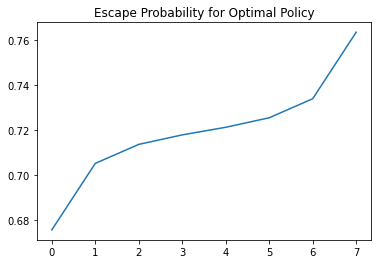

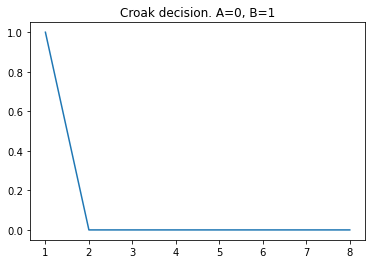

In [8]:
plt.plot(list_of_value_funcs[opt_policy], '-')
plt.title("Escape Probability for Optimal Policy")
plt.show()
decisions = [policies[opt_policy].policy_map[FrogState(i)].sample() for i in range(1,n)]
plt.plot(list(range(1,n)), decisions)
plt.title("Croak decision. A=0, B=1")
plt.show()

# 4

## Action --> Minimize cost --> Minimize $\mathbb{E}[e^{as'}]$

## $ s' \sim N(s,\sigma^2)$

## Minimize $\mathbb{E}[e^{\beta}]$ where $\beta \sim N(as, a^2 \sigma^2)$

## $\mathbb{E}[\beta] = e^{a s + \frac{a^2 \sigma^2}{2}}$

## This is a convex function, so a minimum does exist. Over all $a \in R$, the minimum occurs where:

## $\frac{\partial}{\partial a} = (a \sigma^2 + s) * e^{as + \frac{1}{2}a^2\sigma^2} = 0 $ --> $a\sigma^2 = -s$

## $a = \frac{-s}{\sigma^2}$

This defines the optimal action in any state